<br />

<br />

![](slides/slide0.png)

<br />

<br />

<br />

<br />

![](slides/slide1.png)

<br />

<br />

<br />

<br />

![](slides/slide2.png)

<br />

<br />

<br />

<br />

![](slides/slide3.png)

<br />

<br />

<br />

<br />

![](slides/slide4.png)

<br />

<br />

<br />

<br />

![](slides/slide52.png)

<br />

<br />

<br />

<br />

![](slides/slide62.png)

<br />

<br />

<br />

<br />

In [1]:
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
plt.rcParams['figure.figsize'] = (12, 8)


<br />

<br />

<br />

<br />

## Some Functions

Often used data prep functions. 

In [3]:
def otherise(df_col, n, lst_top_n=None):
        """Otherise dataframe columns if it contains too many values

        Arguments:
            df_col {series} -- dataframe column
            n {int} -- number of maximum values

        Returns:
            series -- dataframe column with reduced values
        """
        if lst_top_n:
            top_n = lst_top_n
        else:
            z = pd.DataFrame(df_col).copy()
            z['val'] = 1
            z.columns = ['key', 'val']
            top_n = z.groupby('key').size().sort_values(ascending=False)[:n]
            top_n = pd.DataFrame(top_n).reset_index()
            top_n = list(top_n.key.values)
        df_col = df_col.apply(lambda y: y if y in top_n else np.NaN)
        
        return df_col

In [4]:
def get_dummies(x):
    """Turn a column of string values into categorical variables through one-hot encoding.

    :param x: Input data frame with original columns
    :type x: Pandas DataFrame
    :returns x: Output data frame with dummy variables
    :rtype x: Pandas DataFrame
    """
    column_names = []
    for i in range(0, len(x.columns)):
        if x.dtypes[i] == 'object':
            column_names.append(x.columns[i])

    dummies = pd.get_dummies(x[column_names])
    x = pd.concat([x.reset_index(drop=True), dummies], axis=1)
    x = x.drop(column_names, axis=1)    

    return x


In [19]:
pd.get_dummies??

## Let's get some data

You can find the entire database of data here:
[Original Postgres DVD Rental database](http://www.postgresqltutorial.com/postgresql-sample-database/)

In [6]:
dvdrental_demographics = pd.read_csv('dvdrental_demographics.csv', index_col=False,  sep = ";")

In [7]:
dvdrental_time = pd.read_csv('dvdrental_time.csv', index_col=False, sep = ";")

In [8]:
dvdrental_pay = pd.read_csv('dvdrental_pay.csv', index_col=False, sep = ";")

In [9]:
dvdrental_preference = pd.read_csv('dvdrental_preference.csv', index_col=False, sep = ";")

<br />

<br />

<br />

<br />

## Data Prep! 90% of all data science work 

### Demographics

Using city and country can be an indicator of different movie tastes. 

Something interesting to try: 

There is a way to use first name to predict gender. Do you think this could be useful when trying to find customer dvd preferences?

In [10]:
dvdrental_demographics['city'] = otherise(dvdrental_demographics['city'], 2)
dvdrental_demographics['country'] = otherise(dvdrental_demographics['country'], 2)

In [11]:
dvdrental_demographics.head(1)

,customer_id,store_id,first_name,address_id,create_date,active,city_id,city,country_id,country
0,524,1,Jared,530,2006-02-14,1.0,419,NaN,45,NaN


In [12]:
aggregations_dm = {
    'store_id': ["max"],
    'city': [lambda x: x.value_counts().index[0] if len(x.value_counts()) else None],
    'country': [lambda x: x.value_counts().index[0] if len(x.value_counts()) else None],
    'active': ["max"]  
    } 

df_dm = dvdrental_demographics.groupby('customer_id').agg(aggregations_dm).reset_index()
df_dm.columns = ['customer_id','store_id','city','country','active']


In [13]:
df_dm.head()

,customer_id,store_id,city,country,active
0,1,1,None,None,1.0
1,2,1,None,None,1.0
2,3,1,None,None,1.0
3,4,2,None,None,1.0
4,5,1,None,None,1.0


In [14]:
df_dm = get_dummies(df_dm)
df_dm.head()

,customer_id,store_id,active,city_Aurora,city_London,country_China,country_India
0,1,1,1.0,0,0,0,0
1,2,1,1.0,0,0,0,0
2,3,1,1.0,0,0,0,0
3,4,2,1.0,0,0,0,0
4,5,1,1.0,0,0,0,0


<br />

<br />

<br />

<br />

### Time features

There's more to do here:
 
 - Frequency between subsequent rentals
 - Finding how long since last rental
 
Can you think of more features?


In [15]:
dvdrental_time['return_date'] = np.where(dvdrental_time['return_date'] == '\\N','2013-05-26 14:50:58' ,dvdrental_time['return_date']) 

dvdrental_time['rental_date'] = pd.to_datetime(dvdrental_time['rental_date'])
dvdrental_time['return_date'] = pd.to_datetime(dvdrental_time['return_date'])

dvdrental_time['rent_time'] = (dvdrental_time['return_date'] - dvdrental_time['rental_date']).astype('timedelta64[D]')


In [16]:
aggregations_time = {
    'rental_date': { # work on the "rental_date" column
        'max_rental_date': 'max',  # get the max, and call this result 'max_rental_date'
        'min_rental_date': 'min', # get min, call result 'min_rental_date'
        'total_dvds': 'count'
    },
    'rent_time': {     # Now work on the "rent_time" column
        'ave_rent_time': 'median'   # Find the median, call the result "ave_rent_time"
        }
}

# Perform groupby aggregation by "customer_id"
df_time = dvdrental_time.groupby('customer_id').agg(aggregations_time).reset_index()
df_time.columns = ['customer_id','max_rental_date','min_rental_date','total_dvds','ave_rent_time']


In [17]:
df_time['total_rental_custom_days'] = (df_time['max_rental_date'] - df_time['min_rental_date']).astype('timedelta64[D]')
df_time.drop(['max_rental_date','min_rental_date'], axis=1, inplace=True)

In [18]:
df_time.head()

,customer_id,total_dvds,ave_rent_time,total_rental_custom_days
0,1,32,3.5,89.0
1,2,27,5.0,88.0
2,3,26,6.0,87.0
3,4,22,3.0,68.0
4,5,38,4.5,261.0


<br />

<br />

<br />

<br />

### Payment information

We can ask questions like:

 - What is the most dvd's they would be willing to rent at a time?
 - What do customers spend per rental order?
 - What is they total they have spent as a customer?
 
ie. who are our high-rollers

In [245]:
dvdrental_pay['rental_date'] = pd.to_datetime(dvdrental_pay['rental_date']).dt.date

In [246]:
# what if more than one movie was rented on one day?
aggregations_ppd = {
    'amount': {
        'max_dvd_amount' : 'max',
        'min_dvd_amount' : 'min',
        'ave_dvd_amount' : 'median',
        'total_amount' : 'sum',
        'total_dvd_rented' : 'count'
    }  
    } 

df_ppd = dvdrental_pay.groupby(['customer_id','rental_date']).agg(aggregations_ppd).reset_index()
df_ppd.columns = ['customer_id','rental_date','max_dvd_amount','min_dvd_amount','ave_dvd_amount','total_amount','total_dvd_rented']


In [247]:
# let's look at lifetime spend
aggregations_pay = {
    'max_dvd_amount': ['max'],
    'min_dvd_amount': ['min'],
    'ave_dvd_amount': ['median'],
    'total_dvd_rented' : {
        'ave_dvds_order' : 'median',
        'max_dvds_order' : 'max'
    },
    'total_amount' :
     {
        'max_order_amount' : 'max',
        'ave_order_amount' : 'median',
        'total_lifetime_amount' : 'sum',
        'total_rental_orders' : 'count'
    }  
    } 

df_pay = df_ppd.groupby('customer_id').agg(aggregations_pay).reset_index()
df_pay.columns = ['customer_id','max_dvd_amount','min_dvd_amount','ave_dvd_amount','ave_dvds_order','max_dvds_order','max_order_amount','ave_order_amount','total_lifetime_amount','total_rental_orders']


In [248]:
df_pay.head()

,customer_id,max_dvd_amount,min_dvd_amount,ave_dvd_amount,ave_dvds_order,max_dvds_order,max_order_amount,ave_order_amount,total_lifetime_amount,total_rental_orders
0,1,9.99,0.99,2.99,1.0,4,16.97,4.99,114.70,18
1,2,10.99,0.99,4.99,1.0,5,30.95,4.99,123.74,13
2,3,10.99,0.99,4.99,1.0,4,24.96,5.98,130.76,17
3,4,8.99,0.99,3.99,1.0,3,11.98,4.99,81.78,15
4,5,9.99,0.99,3.99,1.0,3,12.97,4.98,134.65,25


<br />

<br />

<br />

<br />

### Film preference data
 
What are common customer tastes?

 - Favourite actors
 - Favourite genres
 - Favourite movies
 
We can also make distinctions about customers who rent children's movies, this might be a significant feature.

Can you think of more features?

In [249]:
dvdrental_pref = dvdrental_preference[['customer_id', 'title', 'length', 'rating', 'category', 'actor_name']]


In [250]:
dvdrental_pref.category.unique()

array(['Family', 'Foreign', 'New', 'Travel', 'Music', 'Action',
       'Classics', 'Comedy', 'Sci-Fi', 'Drama', 'Sports', 'Animation',
       'Documentary', 'Games', 'Children', 'Horror'], dtype=object)

In [251]:
dvdrental_pref['kids'] = np.where(dvdrental_pref['category'] == 'Children',1,0)
dvdrental_pref['sports'] = np.where(dvdrental_pref['category'] == 'Sports',1,0)
dvdrental_pref['foreign'] = np.where(dvdrental_pref['category'] == 'Foreign',1,0)

In [252]:
dvdrental_pref.head()

,customer_id,title,length,rating,category,actor_name,kids,sports,foreign
0,524,Secrets Paradise,109.0,G,Family,Reese_Kilmer,0,0,0
1,524,Secrets Paradise,109.0,G,Family,Gene_Willis,0,0,0
2,524,Secrets Paradise,109.0,G,Family,Renee_Tracy,0,0,0
3,524,Secrets Paradise,109.0,G,Family,Whoopi_Hurt,0,0,0
4,524,Secrets Paradise,109.0,G,Family,Kenneth_Hoffman,0,0,0


In [253]:
aggregations_pref = {
    'title': [lambda x: x.value_counts().index[0] if len(x.value_counts()) else None],
    'length': {
        'max_length' : 'max',
        'ave_length' : 'median'
    },
    'rating': [lambda x: x.value_counts().index[0] if len(x.value_counts()) else None],
    'category': [lambda x: x.value_counts().index[0] if len(x.value_counts()) else None],
    'actor_name': [lambda x: x.value_counts().index[0] if len(x.value_counts()) else None],
    'kids' : 'max',
    'sports' : 'max',
    'foreign' : 'max'
    } 

df_pref = dvdrental_pref.groupby('customer_id').agg(aggregations_pref).reset_index()
df_pref.columns = ['customer_id','fav_title','max_length','ave_length','rating','fav_category','fav_actor','kids','sports','foreign']



In [254]:
df_pref.head()

,customer_id,fav_title,max_length,ave_length,rating,fav_category,fav_actor,kids,sports,foreign
0,1,Saturday Lambs,180.0,128.0,PG-13,Comedy,Val_Bolger,0,1,1
1,2,Mummy Creatures,185.0,142.0,NC-17,Sports,Minnie_Zellweger,1,1,0
2,3,Rings Heartbreakers,167.0,97.0,R,Music,Jayne_Nolte,0,1,0
3,4,Hoosiers Birdcage,176.0,122.0,G,Foreign,Kirk_Jovovich,1,1,1
4,5,Agent Truman,175.0,126.0,PG,Classics,Susan_Davis,1,1,1


In [255]:
df_pref.fav_title.unique().size

209

In [256]:
df_pref['fav_title'] = otherise(df_pref['fav_title'], 3)
df_pref['fav_actor'] = otherise(df_pref['fav_actor'], 3)


In [257]:
df_pref = get_dummies(df_pref)
df_pref.head()

,customer_id,max_length,ave_length,kids,sports,foreign,fav_title_Oz Liaisons,fav_title_Telemark Heartbreakers,fav_title_Wedding Apollo,rating_G,...,fav_category_Games,fav_category_Horror,fav_category_Music,fav_category_New,fav_category_Sci-Fi,fav_category_Sports,fav_category_Travel,fav_actor_Jayne_Nolte,fav_actor_Renee_Tracy,fav_actor_Sidney_Crowe
0,1,180.0,128.0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,185.0,142.0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,167.0,97.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,4,176.0,122.0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,175.0,126.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<br />

<br />

<br />

<br />

### Let's get all the data together

In [258]:
dataframes = [df_dm, df_time, df_pay, df_pref]
customer_data = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='left'), dataframes)

customer_data.head()

,customer_id,store_id,active,city_Aurora,city_London,country_China,country_India,total_dvds,ave_rent_time,total_rental_custom_days,...,fav_category_Games,fav_category_Horror,fav_category_Music,fav_category_New,fav_category_Sci-Fi,fav_category_Sports,fav_category_Travel,fav_actor_Jayne_Nolte,fav_actor_Renee_Tracy,fav_actor_Sidney_Crowe
0,1,1,1.0,0,0,0,0,32,3.5,89.0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1.0,0,0,0,0,27,5.0,88.0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,1.0,0,0,0,0,26,6.0,87.0,...,0,0,1,0,0,0,0,1,0,0
3,4,2,1.0,0,0,0,0,22,3.0,68.0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1.0,0,0,0,0,38,4.5,261.0,...,0,0,0,0,0,0,0,0,0,0


In [259]:
customer_data.isna().any().any()

False

<br />

<br />

<br />

<br />

### Have a looksee what the data looks like

In [260]:
dataframes = [dvdrental_demographics[['customer_id',
                                      'store_id',
                                      'active',
                                      'city',
                                      'country']],  
              dvdrental_pay[['customer_id',
                             'amount']], 
              dvdrental_preference[['customer_id',
                                    'title',
                                    'length',
                                    'rating',
                                    'category',
                                    'actor_name',
                                    'language']],
             customer_data[['customer_id',
                           'total_dvds',
                           'ave_rent_time',
                           'total_rental_custom_days',
                           'max_dvd_amount',
                           'min_dvd_amount',
                           'ave_dvd_amount',
                           'ave_dvds_order',
                           'max_dvds_order',
                           'max_order_amount',
                           'ave_order_amount',
                           'total_lifetime_amount',
                           'total_rental_orders',
                           'max_length',
                           'ave_length',
                           'kids',
                           'sports',
                           'foreign',
                           'fav_category_Comedy',
                           'fav_category_Drama',
                           'fav_category_Horror',
                           'fav_category_Sci-Fi'
 ]]]

view_data = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='left'), dataframes)
view_data.dropna(axis=1, inplace=True)
view_data.head()

,customer_id,store_id,active,amount,title,length,rating,category,actor_name,language,...,total_rental_orders,max_length,ave_length,kids,sports,foreign,fav_category_Comedy,fav_category_Drama,fav_category_Horror,fav_category_Sci-Fi
0,524,1,1.0,1.99,Secrets Paradise,109.0,G,Family,Reese_Kilmer,English,...,12,182.0,110.0,0,0,1,0,0,0,0
1,524,1,1.0,1.99,Secrets Paradise,109.0,G,Family,Gene_Willis,English,...,12,182.0,110.0,0,0,1,0,0,0,0
2,524,1,1.0,1.99,Secrets Paradise,109.0,G,Family,Renee_Tracy,English,...,12,182.0,110.0,0,0,1,0,0,0,0
3,524,1,1.0,1.99,Secrets Paradise,109.0,G,Family,Whoopi_Hurt,English,...,12,182.0,110.0,0,0,1,0,0,0,0
4,524,1,1.0,1.99,Secrets Paradise,109.0,G,Family,Kenneth_Hoffman,English,...,12,182.0,110.0,0,0,1,0,0,0,0


In [261]:
view_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119716 entries, 0 to 1119715
Data columns (total 31 columns):
customer_id                 1119716 non-null int64
store_id                    1119716 non-null int64
active                      1119716 non-null float64
amount                      1119716 non-null float64
title                       1119716 non-null object
length                      1119716 non-null float64
rating                      1119716 non-null object
category                    1119716 non-null object
actor_name                  1119716 non-null object
language                    1119716 non-null object
total_dvds                  1119716 non-null int64
ave_rent_time               1119716 non-null float64
total_rental_custom_days    1119716 non-null float64
max_dvd_amount              1119716 non-null float64
min_dvd_amount              1119716 non-null float64
ave_dvd_amount              1119716 non-null float64
ave_dvds_order              1119716 non-null float

In [262]:
view_data.to_csv('view_data.csv', index=False)

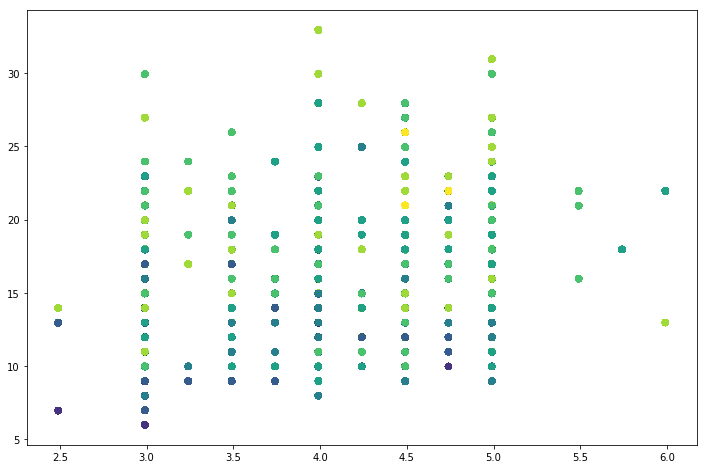

In [263]:
plt.scatter(view_data.ave_dvd_amount, view_data.max_order_amount, c=view_data.max_dvd_amount)

(array([9.67401855e-05, 1.35990728e-04, 1.39215401e-03, 5.31655169e-03,
        1.04156204e-02, 1.44093996e-02, 1.56355048e-02, 1.32696017e-02,
        9.36329725e-03, 6.23113311e-03, 2.29922093e-03, 1.16000675e-03,
        2.51042970e-04, 8.16163240e-04, 8.98020320e-04]),
 array([ 27.93      ,  40.17133333,  52.41266667,  64.654     ,
         76.89533333,  89.13666667, 101.378     , 113.61933333,
        125.86066667, 138.102     , 150.34333333, 162.58466667,
        174.826     , 187.06733333, 199.30866667, 211.55      ]),
 <a list of 15 Patch objects>)

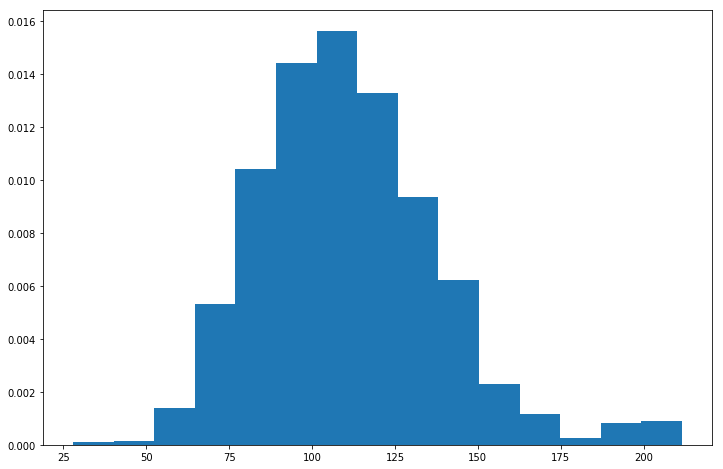

In [264]:
plt.hist(view_data.total_lifetime_amount, bins=15, density=True)

([<matplotlib.patches.Wedge at 0x11e587f98>,
 [Text(0.94431690607104, 0.5641503176533881, 'Comedy'),
  Text(-0.617230023812459, 0.9105092518500135, 'Drama'),
  Text(-0.8383534551246952, -0.7121541155399482, 'Horror'),
  Text(0.6630455009186644, -0.877707618578942, 'Sci-Fi')])

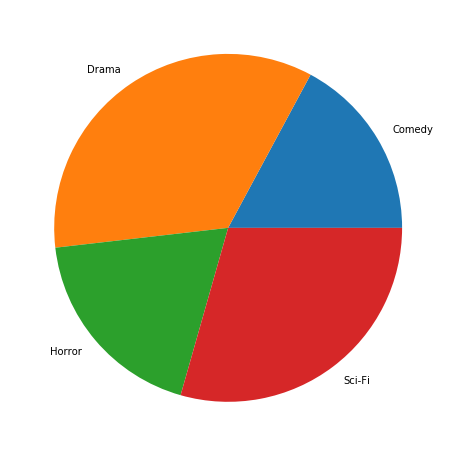

In [265]:
cat_size = [view_data['fav_category_Comedy'].sum(), 
            view_data['fav_category_Drama'].sum(),
            view_data['fav_category_Horror'].sum(),
            view_data['fav_category_Sci-Fi'].sum()]
cat_labels = ['Comedy',
             'Drama',
             'Horror',
             'Sci-Fi']
plt.pie(cat_size, labels=cat_labels)

([<matplotlib.patches.Wedge at 0x10c5009e8>,
 [Text(0.633073043344306, 0.8995657406720081, 'kids'),
  Text(-1.089171458729192, 0.1539660140736394, 'sports'),
  Text(0.4251648948564696, -1.0145121054879962, 'foreign'),
  Text(1.0968278657868409, -0.08347833751030088, 'none')])

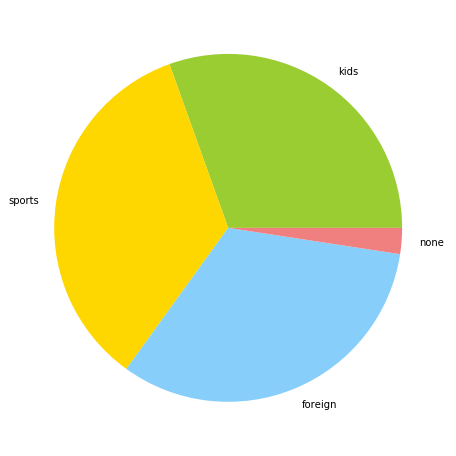

In [266]:
cat_size2 = [view_data['kids'].sum(), 
            view_data['sports'].sum(),
            view_data['foreign'].sum(),
            view_data[(view_data['kids'] == 0) & \
                      (view_data['sports'] == 0) & \
                      (view_data['foreign'] == 0)].shape[0]]
cat_labels2 = ['kids',
             'sports',
             'foreign',
             'none']
plt.pie(cat_size2, labels=cat_labels2, colors=['yellowgreen', 'gold', 'lightskyblue', 'lightcoral'])

<br />

<br />

<br />

<br />

## Let's look at some Algorithms!

#### Preprocessing

Before we can pass our dataset in we may need to do some preprocessing. 

 - We need to scale all our numbers to be of the same order of magnitude, so some numbers don't appear more important than others.
 - We could reduce our feature set.
 - Later we can play around with feature weights.



<br />

<br />

<br />

<br />

#### Machine Learning!

We're doing **unsupervised classification**. We are sorting our customers into groups but we have no idea what sorts of groups they are.

What can we use?

Scikit-Learn has various clustering algorithms. I've tried out a few:

 - **K-Means**
 - **Mini Batch K-Means**
 - **Agglomerative Clustering**
 - **Birch Clustering**
 
![clustering algorithms](img/scikitlearn_clustering.png)

Maybe there's a better algorithm out there! Feel free to try out some others.
[scikit-learn clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering)


<br />

<br />

#### Scoring

We need a way to tell how well we're doing.

 - **Calinski Harabaz score**
 - **Silhouette score**
 
Higher scores mean better defined clusters. 
 
So, let's get going:

<br />

<br />



## Some ML Functions

In [268]:
def standard_normalized_vars(x):
    column_names = []
    for i in range(0,len(x.columns)):
        if x.dtypes[i] in ['int64','float64','uint8']:
            column_names.append(x.columns[i])    
    x[column_names] = x[column_names].fillna(0)
    x[column_names] = x[column_names].astype(float)
    df = x[column_names].values #returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(x_scaled)
    df.columns = column_names
    x[column_names] = df[column_names]
    return x

In [267]:
def pca_reduce(x, comp_n):
    pca_in = x.copy()
    pca_n = PCA(n_components=comp_n, 
          copy=True, 
          whiten=False, 
          svd_solver='auto', 
          tol=0.0, 
          iterated_power='auto', 
          random_state=0)
    X_pca = pca_n.fit(pca_in)
    trans_pca = pca_n.transform(pca_in)
    df_pca = pd.DataFrame(trans_pca)
    variance_ratio = X_pca.explained_variance_ratio_
    print('pca_components ',comp_n,'   describe ',sum(variance_ratio))
    return df_pca


In [269]:
def train_kmeans(x, k):
    KMModel = KMeans(n_clusters=k, 
                     init='k-means++', 
                     n_init=10, 
                     max_iter=600, 
                     tol=0.0001, 
                     precompute_distances='auto', 
                     verbose=0, 
                     random_state=1, 
                     copy_x=True, 
                     n_jobs=1, 
                     algorithm='auto')
    KMModel.fit(x) 
    print("kmeans,", k, "clusters:   ",
          "calinski_harabaz_score", calinski_harabaz_score(x, KMModel.labels_), "   ",
          "silhouette_score", silhouette_score(x, KMModel.labels_),'\n' )
    return KMModel

<br />

<br />

<br />

<br />

Store the customer id for later

In [270]:
ids = customer_data.customer_id.copy()

In [271]:
customer_data.drop('customer_id', axis=1, inplace=True)

### Scaling

Scale so all numbers are proportional

In [272]:
customer_data = standard_normalized_vars(customer_data)

In [273]:
customer_data.head()

,store_id,active,city_Aurora,city_London,country_China,country_India,total_dvds,ave_rent_time,total_rental_custom_days,max_dvd_amount,...,fav_category_Games,fav_category_Horror,fav_category_Music,fav_category_New,fav_category_Sci-Fi,fav_category_Sports,fav_category_Travel,fav_actor_Jayne_Nolte,fav_actor_Renee_Tracy,fav_actor_Sidney_Crowe
0,-0.915108,0.160265,-0.05788,-0.05788,-0.31156,-0.333642,1.021400,-1.212015,-0.534638,0.596795,...,-0.195265,-0.195265,-0.225560,-0.241462,-0.25287,-0.363765,-0.217262,-0.136775,-0.142979,-0.148944
1,-0.915108,0.160265,-0.05788,-0.05788,-0.31156,-0.333642,0.042177,0.463363,-0.547484,1.372224,...,-0.195265,-0.195265,-0.225560,-0.241462,-0.25287,2.749026,-0.217262,-0.136775,-0.142979,-0.148944
2,-0.915108,0.160265,-0.05788,-0.05788,-0.31156,-0.333642,-0.153668,1.580281,-0.560330,1.372224,...,-0.195265,-0.195265,4.433415,-0.241462,-0.25287,-0.363765,-0.217262,7.311262,-0.142979,-0.148944
3,1.092767,0.160265,-0.05788,-0.05788,-0.31156,-0.333642,-0.937046,-1.770474,-0.804402,-0.178633,...,-0.195265,-0.195265,-0.225560,-0.241462,-0.25287,-0.363765,-0.217262,-0.136775,-0.142979,-0.148944
4,-0.915108,0.160265,-0.05788,-0.05788,-0.31156,-0.333642,2.196467,-0.095097,1.674857,0.596795,...,-0.195265,-0.195265,-0.225560,-0.241462,-0.25287,-0.363765,-0.217262,-0.136775,-0.142979,-0.148944


<br />

<br />

<br />

<br />

And finally: 

## Cluster

(and PCA)

In [275]:
pca_components = [25, 35, 45]
clusters = [3, 6, 12]
for cmp in pca_components:
    for k in clusters:
        df = customer_data.copy()
        # reduce features
        pca_df = pca_reduce(df, cmp)
        
        #cluster!
        model = train_kmeans(pca_df, k)
        

pca_components  25    describe  0.6945709877420538
kmeans, 3 clusters:    calinski_harabaz_score 31.069651746409004     silhouette_score 0.04902108167832047 

pca_components  25    describe  0.6945709877420538
kmeans, 6 clusters:    calinski_harabaz_score 23.53672256261991     silhouette_score 0.060831705329709926 

pca_components  25    describe  0.6945709877420538
kmeans, 12 clusters:    calinski_harabaz_score 23.238773956466495     silhouette_score 0.11794422676859828 

pca_components  35    describe  0.8693739769924131
kmeans, 3 clusters:    calinski_harabaz_score 24.766559774690986     silhouette_score 0.05181570576869992 

pca_components  35    describe  0.8693739769924131
kmeans, 6 clusters:    calinski_harabaz_score 19.676805670919894     silhouette_score 0.04233972871701674 

pca_components  35    describe  0.8693739769924131
kmeans, 12 clusters:    calinski_harabaz_score 20.276667304666802     silhouette_score 0.10856056807847157 

pca_components  45    describe  0.9913571282

In [276]:
pca_df = pca_reduce(df, 35)
model = train_kmeans(pca_df, 3)

pca_components  35    describe  0.8693739769924131
kmeans, 3 clusters:    calinski_harabaz_score 24.766559774690986     silhouette_score 0.05181570576869992 



<br />

<br />

<br />

<br />

## Let's explore the clusters

#### 3D view

It can help to plot a 3-D PCA of the clusters with lables to get a feel for the clusters.

In [277]:
def pca_3d(df):   
    pca = PCA(n_components=3, 
          copy=True, 
          whiten=False, 
          svd_solver='auto', 
          tol=0.0, 
          iterated_power='auto', 
          random_state=0)
    X_pca = pca.fit(df)
    trans_pca = X_pca.transform(df)
    pca3_df = pd.DataFrame(trans_pca)
    pca3_df.columns = ['x','y','z']
    print('explained_variance_ratio', X_pca.explained_variance_ratio_)
    
    return pca3_df

Add cluster labels to the 3D view of the clusters, as well as the original feature set.

In [278]:
pca3_df = pca_3d(pca_df)

clusters = pd.DataFrame(model.labels_)
clusters.columns = ['clusters']

df_3d = pd.concat([pca3_df, clusters], axis=1, join='inner')


explained_variance_ratio [0.08658236 0.04585693 0.04056917]


##### Our explained variance ratio is terrible!
Clearly we have too many features of too little importance. If we plot against these unimportant features, I don't think we will see distinct groupings. </br>
</br>

In [280]:
plt.rcParams['figure.figsize'] = (12, 8)

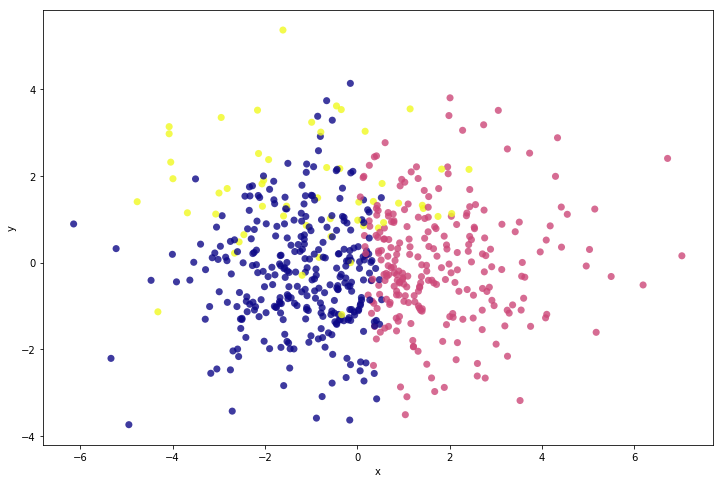

In [294]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_3d.x.values, df_3d.y.values, s=50, lw=0,
           c=df_3d.clusters.values, cmap='plasma', alpha=0.8)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

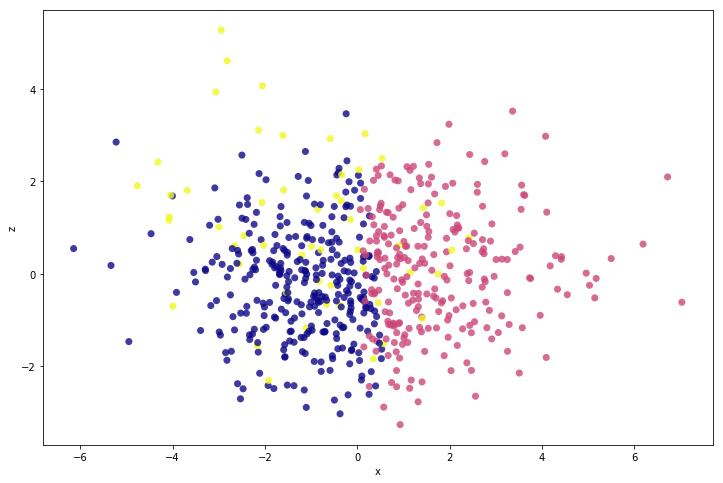

In [295]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_3d.x.values, df_3d.z.values, s=50, lw=0,
           c=df_3d.clusters.values, cmap='plasma', alpha=0.8)

ax.set_xlabel('x')
ax.set_ylabel('z')
plt.show()

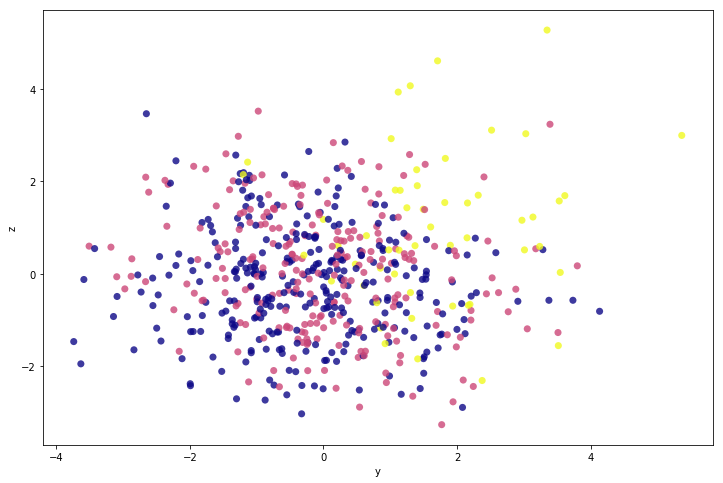

In [297]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_3d.y.values, df_3d.z.values, s=50, lw=0,
           c=df_3d.clusters.values, cmap='plasma', alpha=0.8)

ax.set_xlabel('y')
ax.set_ylabel('z')
plt.show()

<br />

<br />

<br />

<br />

### What about features vs cluster?

In [301]:
features = view_data.groupby('customer_id').median().reset_index()
cluster_features = pd.concat([features, clusters], axis=1, join='inner')

In [302]:
cluster_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 27 columns):
customer_id                 599 non-null int64
store_id                    599 non-null int64
active                      599 non-null float64
amount                      599 non-null float64
length                      599 non-null float64
total_dvds                  599 non-null int64
ave_rent_time               599 non-null float64
total_rental_custom_days    599 non-null float64
max_dvd_amount              599 non-null float64
min_dvd_amount              599 non-null float64
ave_dvd_amount              599 non-null float64
ave_dvds_order              599 non-null float64
max_dvds_order              599 non-null int64
max_order_amount            599 non-null float64
ave_order_amount            599 non-null float64
total_lifetime_amount       599 non-null float64
total_rental_orders         599 non-null int64
max_length                  599 non-null float64
ave_length             

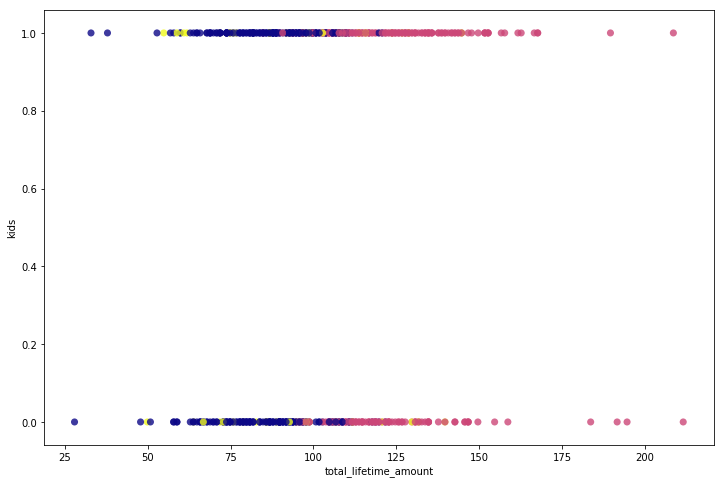

In [304]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(cluster_features.total_lifetime_amount.values, cluster_features.kids.values, s=50, lw=0,
           c=cluster_features.clusters.values, cmap='plasma', alpha=0.8)

ax.set_xlabel('total_lifetime_amount')
ax.set_ylabel('kids')
plt.show()

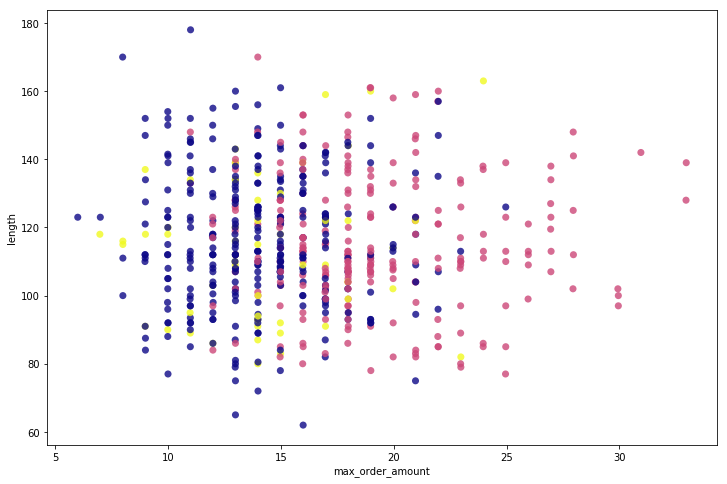

In [309]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(cluster_features.max_order_amount.values, cluster_features.length.values, s=50, lw=0,
           c=cluster_features.clusters.values, cmap='plasma', alpha=0.8)

ax.set_xlabel('max_order_amount')
ax.set_ylabel('length')
plt.show()

<br />

<br />

<br />

<br />

![](slides/google_dataproc.png)

<br />

<br />

<br />

<br />

## The fun part: tweaking the weights and designing new features!

In [284]:
# more weight:
weight_up = 1.2
customer_data['max_dvd_amount'] = customer_data['max_dvd_amount']*(weight_up)
customer_data['total_lifetime_amount'] = customer_data['total_lifetime_amount']*(weight_up)

# less weight:
weight_down = 0.8
customer_data['min_dvd_amount'] = customer_data['min_dvd_amount']*(weight_down)
customer_data['foreign'] = customer_data['foreign']*(weight_down)


In [285]:
customer_data['ave_rental_freq'] = (customer_data['total_rental_custom_days'] / customer_data['total_rental_orders'])


<br />

<br />

<br />

<br />

## Some more algorithms to play with

In [286]:
from sklearn.cluster import Birch,MiniBatchKMeans,AgglomerativeClustering


In [287]:
def train_birch(x,k):
    # Fit Birch clusters using Characteristic Feature Tree (CFT) algorithm.
    # The algorthm has two limiting factors: the branching factor limits the number of subclusters per node, 
    # and the threshold limits the distance between a new point and an existing subcluster.
    # CF subclusters retain the subscluster information such as linear sums, squared sums, and centroids of subclusters.
    # A new point is merged with a subcluster which has the smallest radius after merging.
    # This is contrained by the limiting factors, else the point becomes its own new subcluster.
    # Birch allows online-learning memory efficient a;ternative to minibatch kmeans, which doesn't require redrawing the tree.
    # http://scikit-learn.org/stable/modules/clustering.html for more reading.
    
    # Input parameters : 
    # x: dataframe of features
    # i: number of clusters
    
    # Output :
    # trained model
    
    from sklearn.cluster import Birch
    from sklearn import metrics

    brch = Birch(branching_factor=50, n_clusters=None, threshold=0.1, compute_labels=True, copy=True)
    brch.partial_fit(x)
    brch.set_params(n_clusters=k)
    brch.partial_fit()
    brch.partial_fit()
    brch.fit(x)
    brchlabels=brch.labels_
    print("birch,", k, "clusters:   ",
          "calinski_harabaz_score", calinski_harabaz_score(x, KMModel.labels_), "   ",
          "silhouette_score", silhouette_score(x, KMModel.labels_),'\n' )
    return brch

In [288]:
def train_ward(x,k):
    # Fit Agglomerative clusters with ward clustering 
    # Agglomerative clusters use a hierarchical approach: all points start as their own clusters and then lerge into new clusters depending on certain criteria
    # Ward reduces the sum of the squared distances inside all clusters, meaning the clusters are tighly grouped,
    # and is ideal for many, evenly sized clusters in Euclidean space
    # When there is no connectivity matrix supplied, this is computationally expensive as it consideres each possible combination
    # http://scikit-learn.org/stable/modules/clustering.html for more reading.
    
    # Input parameters : 
    # x: dataframe of features
    # i: number of clusters
    
    # Output :
    # trained model
    
    from sklearn.cluster import AgglomerativeClustering
    from sklearn import metrics

    agglom = AgglomerativeClustering(linkage='ward', n_clusters=k)
    agglom.fit(x)
    aglabels=agglom.labels_
    print("ward,", k, "clusters:   ",
          "calinski_harabaz_score", calinski_harabaz_score(x, KMModel.labels_), "   ",
          "silhouette_score", silhouette_score(x, KMModel.labels_),'\n' )
    return agglom

In [289]:
def train_cosagglom(x,k):
    # Fit Agglomerative clusters with ward clustering 
    # Agglomerative clusters use a hierarchical approach: all points start as their own clusters and then lerge into new clusters depending on certain criteria
    # Average linkage minimises the distances between centroids, giving clusters grouped evenly together,
    # and can be used with Euclidean space as well as Cosine or Manhattan distance.
    # When there is no connectivity matrix supplied, this is computationally expensive as it consideres each possible combination
    # http://scikit-learn.org/stable/modules/clustering.html for more reading.
    
    # Input parameters : 
    # x: dataframe of features
    # i: number of clusters
    
    # Output :
    # trained model
    
    from sklearn.cluster import AgglomerativeClustering
    from sklearn import metrics

    csagglom = AgglomerativeClustering(linkage='average', n_clusters=k, affinity='cosine', compute_full_tree=False)
    csagglom.fit(x)
    csaglabels=csagglom.labels_
    print("cosine,", k, "clusters:   ",
          "calinski_harabaz_score", calinski_harabaz_score(x, KMModel.labels_), "   ",
          "silhouette_score", silhouette_score(x, KMModel.labels_),'\n' )
    return csagglom

In [290]:
def train_minibatch(x,k):
    # Fit MiniBatchKMeans clusters using Characteristic Feature Tree (CFT) algorithm.
    # The algorthm has two limiting factors: the branching factor limits the number of subclusters per node, 
    # and the threshold limits the distance between a new point and an existing subcluster.
    # CF subclusters retain the subscluster information such as linear sums, squared sums, and centroids of subclusters.
    # A new point is merged with a subcluster which has the smallest radius after merging.
    # This is contrained by the limiting factors, else the point becomes its own new subcluster.
    # MiniBatchKMeans is good for high-dimensional datasets with many features.
    # http://scikit-learn.org/stable/modules/clustering.html for more reading.
    
    # Input parameters : 
    # x: dataframe of features
    # i: number of clusters
    
    # Output :
    # trained model
    
    from sklearn.cluster import MiniBatchKMeans
    from sklearn import metrics

    minibatchm = MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=3*k,
                      n_init=10, max_no_improvement=20, verbose=0,
                      random_state=0)
    minibatchm.fit(x)
    minilabels=minibatchm.labels_
    print("minibatch,", k, "clusters:   ",
          "calinski_harabaz_score", calinski_harabaz_score(x, KMModel.labels_), "   ",
          "silhouette_score", silhouette_score(x, KMModel.labels_),'\n' )
    return minibatchm

<br />

<br />

<br />

<br />

![](slides/slide7.png)

<br />

<br />

<br />

<br />

![](slides/slide8.png)

<br />

<br />

<br />

<br />

![](slides/slide9.png)

<br />

<br />

<br />

<br />

![](slides/slide102.png)

<br />

<br />

<br />